In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import PyTorch
import torch
import torchvision.transforms as transforms #Image transformations in tensors
from torch.utils.data import Subset #Dimensionality reduction
import torch.nn as nn  #Define neural network layers
import torch.nn.functional as F #Activation functions
from torch.utils.data import TensorDataset, DataLoader, Dataset,random_split #Creation of training and validation datasets and dataloaders.
import torch.optim as optim #Definition of optimizers

# Import sklearn
from sklearn.model_selection import train_test_split #Division of data in training and validation

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

#Import PIL
from PIL import Image #Image processing

In [3]:
print(os.listdir("../input/histopathologic-cancer-detection"))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [4]:
# Load the file train_labels.csv in a DataFrame
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Check the first rows
print(train_labels.head())

#  Divide the train DataFrame into training and validation sets.
train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])


print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Training set size: 176020
Validation set size: 44005


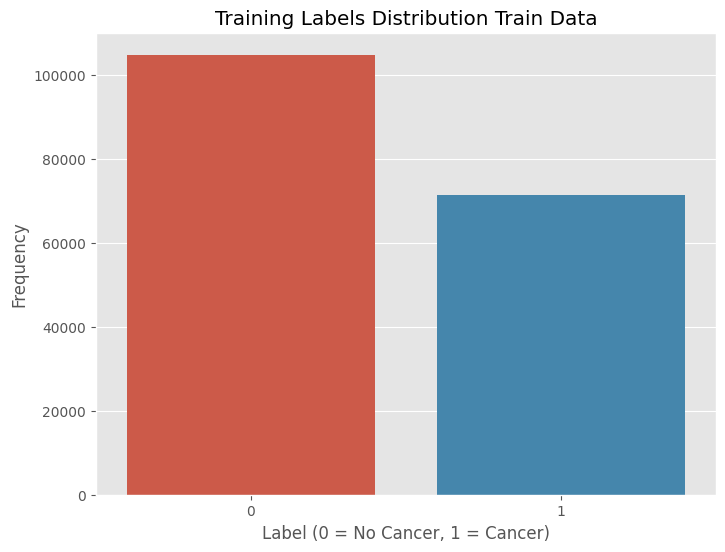

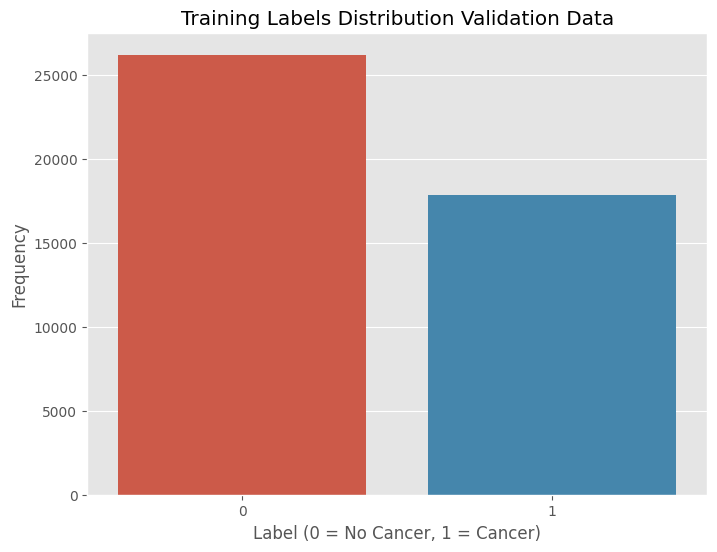

In [5]:
# Analyze distribution of labels in the training dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_data)
plt.title('Training Labels Distribution Train Data')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Frequency')
plt.show()

# Analyze distribution of labels in the training dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=val_data)
plt.title('Training Labels Distribution Validation Data')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Frequency')
plt.show()

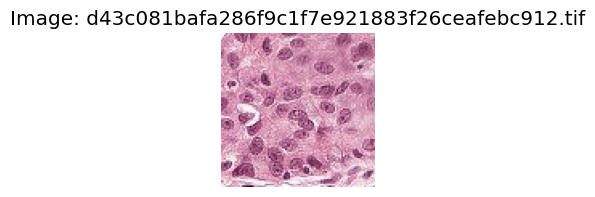

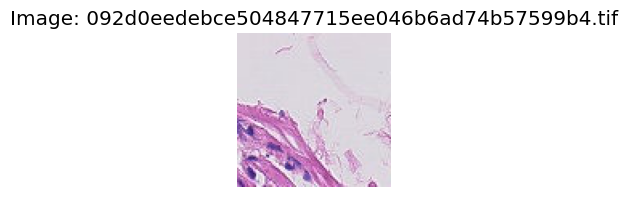

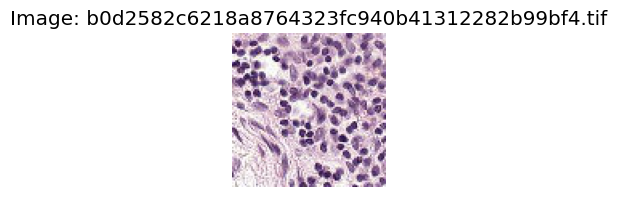

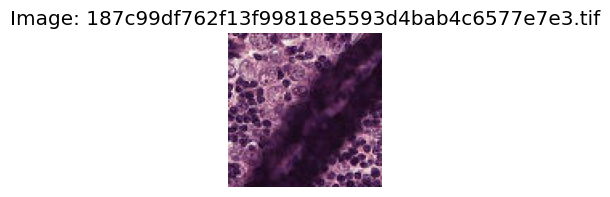

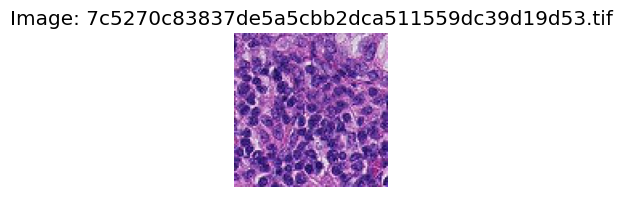

In [6]:
# Directory where the images are located
train_dir = '../input/histopathologic-cancer-detection/train/'
image_files = os.listdir(train_dir)

# Show first 5 images
for img_file in image_files[:5]:  
    img_path = os.path.join(train_dir, img_file)
    
    img = Image.open(img_path)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(img)
    plt.title(f'Image: {img_file}')
    plt.axis('off')
    plt.show()

In [7]:
# Define transformations: resize to 96x96, convert to tensor and normalize
transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Create training dataset
class CancerDataSet(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['id']
        label = self.dataframe.iloc[idx]['label']

        image_path = os.path.join(self.image_dir, image_id + '.tif')
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Create an instance of the dataset
image_dir = "../input/histopathologic-cancer-detection/train" 
train_dataset = CancerDataSet(dataframe=train_data, image_dir=image_dir, transform=transform)
val_dataset= CancerDataSet(dataframe=val_data, image_dir=image_dir, transform=transform)

In [9]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [10]:
# Create Binary CNN
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        
        #Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        #Fully Connected layers
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 2) #output layer - 2 labels

        #Dropout - Helps prevent overfitting
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, H/4, W/4]
        x = x.view(x.size(0), -1)             # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)        
        return x

In [11]:
model = BinaryCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()        

    train_accuracy = 100* correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

Epoch [1/3], Loss: 2146.3678, Training Accuracy: 83.49%
Epoch [2/3], Loss: 1783.8484, Training Accuracy: 86.67%
Epoch [3/3], Loss: 1631.7005, Training Accuracy: 87.90%


In [13]:
# Create dataset for test set
class CancerTestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['id']
        image_path = os.path.join(self.image_dir, image_id + '.tif')
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, image_id

In [14]:
# Load test labels
test_df = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_dir = '../input/histopathologic-cancer-detection/test'

In [15]:
# Create test dataset and dataloader
test_dataset = CancerTestDataset(test_df, test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# Generate predictions on the test set
model.eval()
preds = []
image_ids = []
with torch.no_grad():
    for inputs, img_ids in test_dataloader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        cancer_probs = probs[:, 1].cpu().numpy()
        preds.extend(cancer_probs)
        image_ids.extend(img_ids)


In [17]:
# Create a DataFrame with predictions
submission = pd.DataFrame({'id': image_ids, 'label': preds})
submission['label'] = submission['label'].clip(0, 1)  # Ensures [0, 1] range
submission.to_csv('/kaggle/working/submission.csv', index=False)